In [ ]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import argparse

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/instaDeep/src/protein_universe_annotate')

In [ ]:
from data_processing import read_pfam_dataset

In [ ]:
from data_exploration import *

In [ ]:
data_partitions_dirpath = '/content/drive/MyDrive/instaDeep/data/random_split/'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['dev', 'test', 'train']


In [ ]:
# Print the available dataset partitions
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

# Read each dataset partition into a pandas DataFrame
dev_df = read_pfam_dataset('dev', data_partitions_dirpath)
test_df = read_pfam_dataset('test', data_partitions_dirpath)
train_df = read_pfam_dataset('train', data_partitions_dirpath)

Available dataset partitions:  ['dev', 'test', 'train']


In [ ]:
# Assign the dataset type to each sample by adding a new 'split' column
dev_df['split'] = 'dev'
test_df['split'] = 'test'
train_df['split'] = 'train'

In [ ]:
# Convert true labels from PF00001.21 to PF00001
dev_df['true_label'] = dev_df.family_accession.apply(lambda s: s.split('.')[0])
test_df['true_label'] = test_df.family_accession.apply(lambda s: s.split('.')[0])
train_df['true_label'] = train_df.family_accession.apply(lambda s: s.split('.')[0])

In [ ]:
# Extract length of sequence
dev_df['sequence_len'] = dev_df['sequence'].apply(lambda x: len(x))
test_df['sequence_len'] = test_df['sequence'].apply(lambda x: len(x))
train_df['sequence_len'] = train_df['sequence'].apply(lambda x: len(x))

In [ ]:
# Concatenate the datasets in one DataFrame
total_data_df = pd.concat([test_df, dev_df, train_df], ignore_index=True)

In [ ]:
# Basic info
print(f"Number of samples from dev-test-train: {total_data_df.shape[0]}")
print(f"Number of features: {total_data_df.shape[1]}")
print(f"Features: {total_data_df.columns.tolist()}")

print(f"Dev size: {dev_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")
print(f"Train size: {train_df.shape[0]}")

Number of samples from dev-test-train: 1339083
Number of features: 8
Features: ['family_id', 'sequence_name', 'family_accession', 'aligned_sequence', 'sequence', 'split', 'true_label', 'sequence_len']
Dev size: 126171
Test size: 126171
Train size: 1086741


In [ ]:
# Check for missing values in each column
print('Missing values in dataset: \n', total_data_df.isnull().sum())

Missing values in dataset: 
 family_id           0
sequence_name       0
family_accession    0
aligned_sequence    0
sequence            0
split               0
true_label          0
sequence_len        0
dtype: int64


In [ ]:
# checking for duplicates on the sample level
print(f'Duplicated entries in dataset: {total_data_df.duplicated().any()}')

# Check for duplicates on 'sequence' level in each dataset split
train_duplicates = train_df[train_df.duplicated(subset=['sequence'], keep='first')]
print(f'Num. duplicates in Train: {train_duplicates.shape[0]}')

test_duplicates = test_df[test_df.duplicated(subset=['sequence'], keep='first')]
print(f'Num. duplicates in Test: {test_duplicates.shape[0]}')

dev_duplicates = dev_df[dev_df.duplicated(subset=['sequence'], keep='first')]
print(f'Num. duplicates in Dev: {dev_duplicates.shape[0]}')

Duplicated entries in dataset: False
Num. duplicates in Train: 426
Num. duplicates in Test: 10
Num. duplicates in Dev: 21


In [ ]:
# Does the target label like PF00001 have multiple versions?
print('The target variable \'family_accession\' contains only unique mapping to its version: {}'.
        format(is_bijection_mapping(total_data_df, col1='true_label', col2='family_accession')))

The target variable 'family_accession' contains only unique mapping to its version: True


In [ ]:
# Does the 'family_id' and 'true_label' have 1:1 mapping?
print('The \'family_id\' feature contains only unique mapping to true_label feature: {}'.
        format(is_bijection_mapping(total_data_df, col1='family_id', col2='true_label')))

The 'family_id' feature contains only unique mapping to true_label feature: True


**Conclusion**: The target variable 'family_accession' contains only unique mapping to its version

In [ ]:
num_distinct_labels = total_data_df['true_label'].nunique()
print(f"There are {num_distinct_labels} distinct values in the 'true_label' column.")

There are 17929 distinct values in the 'true_label' column.


In [ ]:
print('Number of unique classes in Train: ', train_df['true_label'].nunique())
print('Number of unique classes in Test: ', test_df['true_label'].nunique())
print('Number of unique classes in Dev: ', dev_df['true_label'].nunique())

Number of unique classes in Train:  17929
Number of unique classes in Test:  13071
Number of unique classes in Dev:  13071




---



---



In [ ]:
# Are there overlaps between sets in 'true_label'?
overlapping_vals = compute_overlap(train_df, test_df, 'true_label')
print(f'Number of overlapping labels Train -- Test: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(train_df, dev_df, 'true_label')
print(f'Number of overlapping labels Train -- Dev: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(dev_df, test_df, 'true_label')
print(f'Number of overlapping labels Dev -- Test: {len(overlapping_vals)}')

Number of overlapping labels Train -- Test: 13071
Number of overlapping labels Train -- Dev: 13071
Number of overlapping labels Dev -- Test: 13071


In [ ]:
print('Unique target labels in test dataset: {}'.format(test_df['true_label'].nunique()))
print('Unique target labels in dev dataset: {}'.format(dev_df['true_label'].nunique()))

Unique target labels in test dataset: 13071
Unique target labels in dev dataset: 13071


All true labels (to be predicted) from test and dev dataset are included in the training dataset.

In [ ]:
# Are there overlaps between sets in 'sequence'?
overlapping_vals = compute_overlap(train_df, test_df, 'sequence')
print(f'Number of overlapping sequences Train -- Test: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(train_df, dev_df, 'sequence')
print(f'Number of overlapping sequences Train -- Dev: {len(overlapping_vals)}')

overlapping_vals = compute_overlap(test_df, dev_df, 'sequence')
print(f'Number of overlapping sequences Test -- Dev: {len(overlapping_vals)}')

Number of overlapping sequences Train -- Test: 60
Number of overlapping sequences Train -- Dev: 67
Number of overlapping sequences Test -- Dev: 18


**Conclusion**: Overlap less than 0.01% so all good! The number of overlapping sequences (input to ML models) is too low to have any negative impact, so can be ignored at the moment.

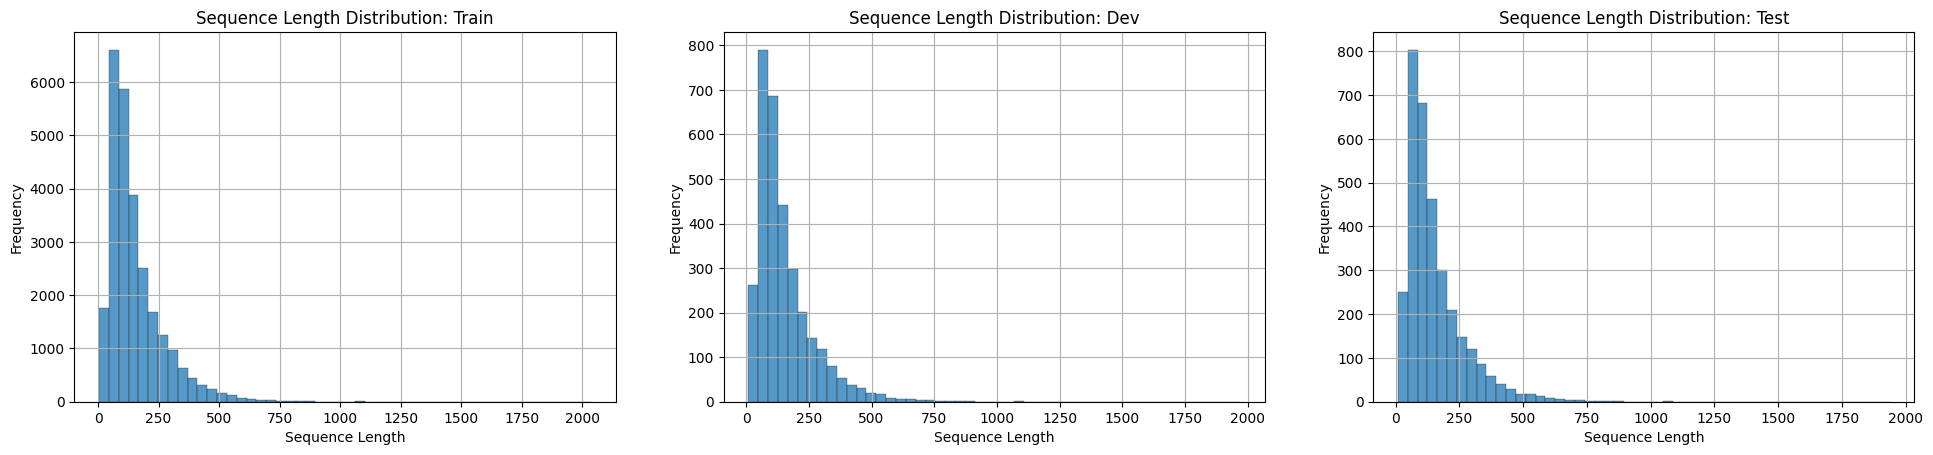

In [ ]:
plt.subplot(1, 3, 1)
plot_sequence_len_dist(train_df, 'Train')

plt.subplot(1, 3, 2)
plot_sequence_len_dist(dev_df, 'Dev')

plt.subplot(1, 3, 3)
plot_sequence_len_dist(test_df, 'Test')

plt.subplots_adjust(right=3.0)
plt.savefig('sequence_len_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
dev_df['sequence'].apply(len).describe()

count    126171.000000
mean        154.222206
std         118.278250
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1971.000000
Name: sequence, dtype: float64

In [ ]:
test_df['sequence'].apply(len).describe()

count    126171.000000
mean        154.166845
std         118.376706
min           9.000000
25%          76.000000
50%         118.000000
75%         194.000000
max        1937.000000
Name: sequence, dtype: float64

In [ ]:
train_df['sequence'].apply(len).describe()

count    1.086741e+06
mean     1.553800e+02
std      1.201232e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence, dtype: float64

**Conclusion**: Most of the input sequences have length in range \[50-250\].

<Axes: xlabel='sequence_len'>

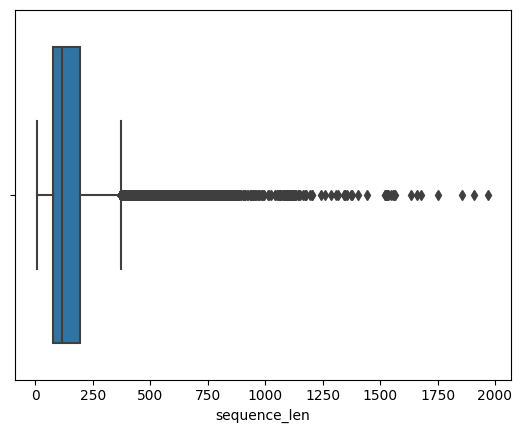

In [ ]:
sns.boxplot(x=dev_df['sequence_len'])

<Axes: xlabel='sequence_len'>

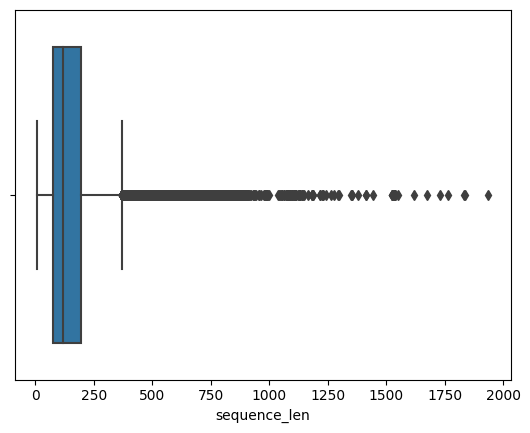

In [ ]:
sns.boxplot(x=test_df['sequence_len'])

<Axes: xlabel='sequence_len'>

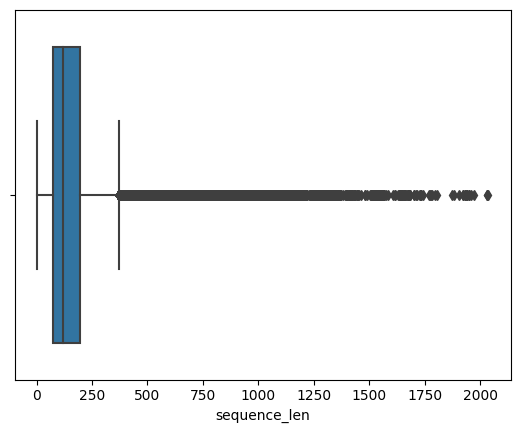

In [ ]:
sns.boxplot(x=train_df['sequence_len'])

In [ ]:
dev_outliers = detect_outliers_zscore(dev_df, 'sequence_len')
test_outliers = detect_outliers_zscore(test_df, 'sequence_len')
train_outliers = detect_outliers_zscore(train_df, 'sequence_len')

In [ ]:
print(f'Num. significantly longer sequences in Dev: {(len(dev_outliers) / len(dev_df)) * 100} %')
print(f'Num. significantly longer sequences in Test: {(len(test_outliers) / len(test_df)) * 100} %')
print(f'Num. significantly longer sequences in Train: {(len(train_outliers) / len(train_df)) * 100} %')

Num. significantly longer sequences in Dev: 1.8403595120907341 %
Num. significantly longer sequences in Test: 1.8673070673926655 %
Num. significantly longer sequences in Train: 1.8375123419471613 %


**Conclusion**: Around 2% of all sequences are singificantly longer, yet these are not outliers per se and should be kept in the dataset. (just too long protein sequence, not abnormal)

In [ ]:
# Get the frequency of each amino acid in the sequences of a given DataFrame
dev_amino_acid_freq = get_amino_acid_freq(dev_df, 'Dev')
test_amino_acid_freq = get_amino_acid_freq(test_df, 'Test')
train_amino_acid_freq = get_amino_acid_freq(train_df, 'Train')

	##### Dev
Total unique Amino Acids: 22
	##### Test
Total unique Amino Acids: 24
	##### Train
Total unique Amino Acids: 25


In [ ]:
# Are amino acids same across sets?
print('Are all test amino acids covered in train: ',
        set(train_amino_acid_freq['amino_acid'].values).issuperset(set(test_amino_acid_freq['amino_acid'].values)))
print('Are all dev amino acids covered in train: ',
        set(train_amino_acid_freq['amino_acid'].values).issuperset(set(dev_amino_acid_freq['amino_acid'].values)))
print('Are all dev amino acids covered in test: ',
        set(test_amino_acid_freq['amino_acid'].values).issuperset(set(dev_amino_acid_freq['amino_acid'].values)))

Are all test amino acids covered in train:  True
Are all dev amino acids covered in train:  True
Are all dev amino acids covered in test:  True


In [ ]:
train_amino_acid_freq['amino_acid'].values

array(['L', 'A', 'V', 'G', 'E', 'S', 'I', 'R', 'D', 'K', 'T', 'P', 'F',
       'N', 'Q', 'Y', 'M', 'H', 'C', 'W', 'X', 'U', 'B', 'O', 'Z'],
      dtype=object)

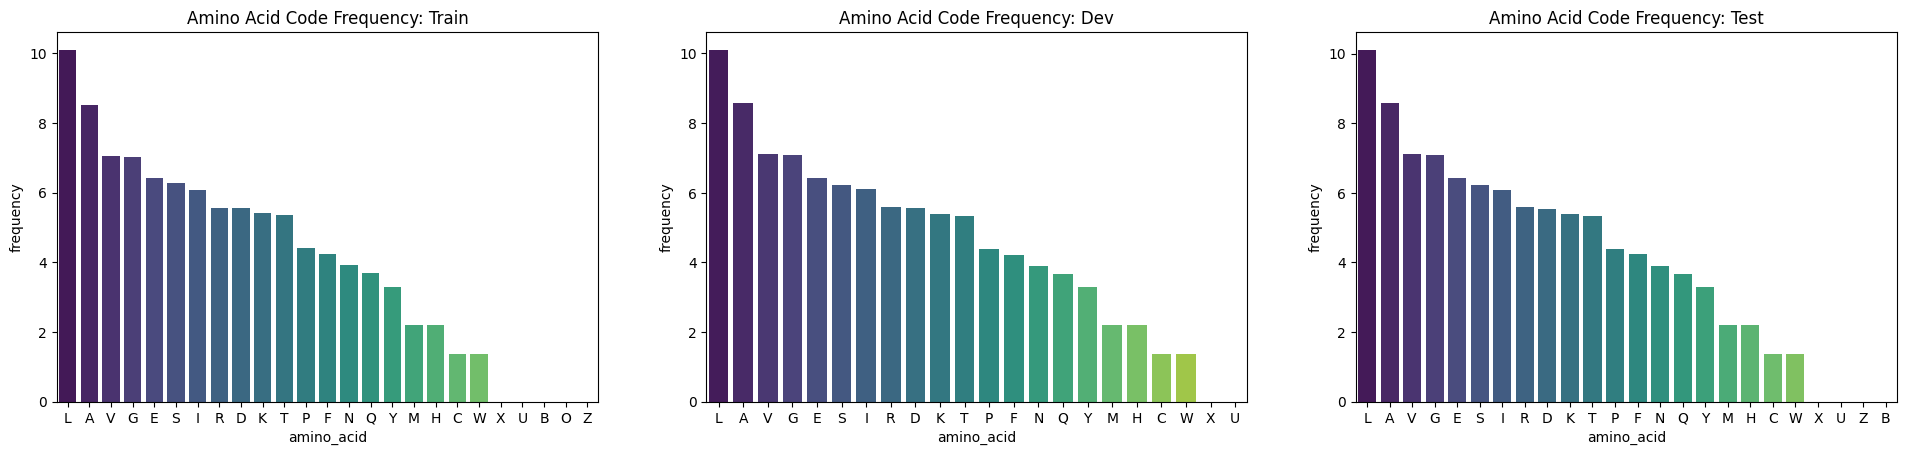

In [ ]:
# Plot the frequency of amino acid codes in a given dataset.

plt.subplot(1, 3, 1)
plot_code_freq(train_amino_acid_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(dev_amino_acid_freq, 'Dev')

plt.subplot(1, 3, 3)
plot_code_freq(test_amino_acid_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.savefig('amino_acid_codes_dist.png', dpi=300, bbox_inches='tight')
plt.show()

Find out protein families with most sequences(No. of observations)


In [ ]:
train_df.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [ ]:
dev_df.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [ ]:
test_df.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
THF_DHG_CYH        138
Prenyltransf       138
HTH_1              133
Maf                132
DHH                131
dtype: int64

**Conclusion**: Top 20 classes are same across all the sets train, test, dev. Test and Dev sets have almost same frequency for the top 20 classes.

Following are the plots of the most frequent family_ids and their counts


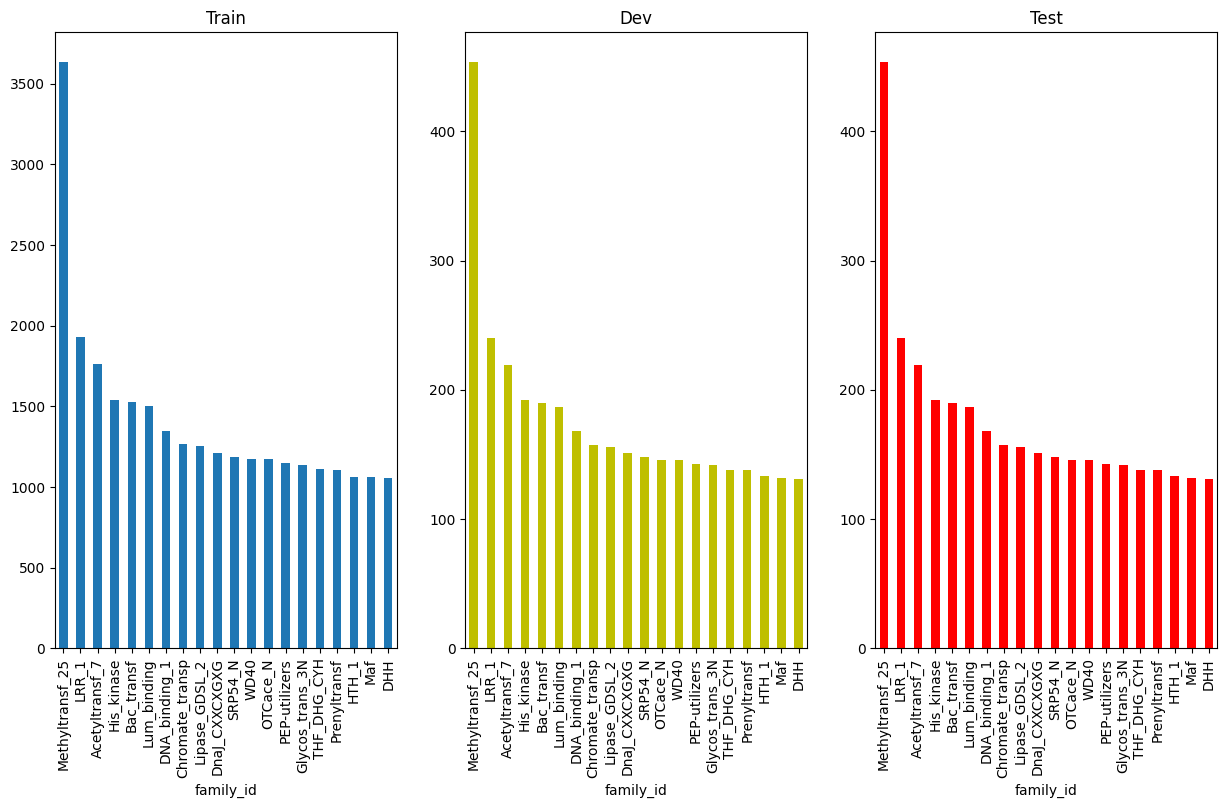

In [ ]:
print('Following are the plots of the most frequent family_ids and their counts')
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.title('Train')
train_df.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar')

plt.subplot(1,3,2)
plt.title('Dev')
dev_df.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar',color='y')

plt.subplot(1,3,3)
plt.title('Test')
test_df.groupby('family_id').size().sort_values(ascending=False).head(20).plot(kind='bar',color='red')

plt.savefig('family_ids_TOP_popular.png', dpi=300, bbox_inches='tight')
plt.show()

Find out the Family ID (true label) distribution - Check for class imbalance

In [ ]:
def plot_family_dist(data_df, split_name, bins=50):

    family_sizes = data_df.groupby('true_label').size()

    # if threshold_pos:
    #     family_sizes_sorted = family_sizes.sort_values(ascending=False)

    #     # max_occurrences
    #     max_occurrences = family_sizes_sorted[threshold_pos]
    #     print(f'The max_occurrences at {threshold_pos}: {max_occurrences}')
    #     print(f'Family ID sizes with cound < {max_occurrences} will be displayed!')

    #     # Keep entries below the threshold
    #     family_sizes = family_sizes[family_sizes < max_occurrences]
    
    sns.histplot(family_sizes, stat='frequency', bins=bins)
    plt.title(f'Distribution of <true_label> occurrences for {split_name}')
    plt.xlabel('True label occurence')
    plt.grid(True)

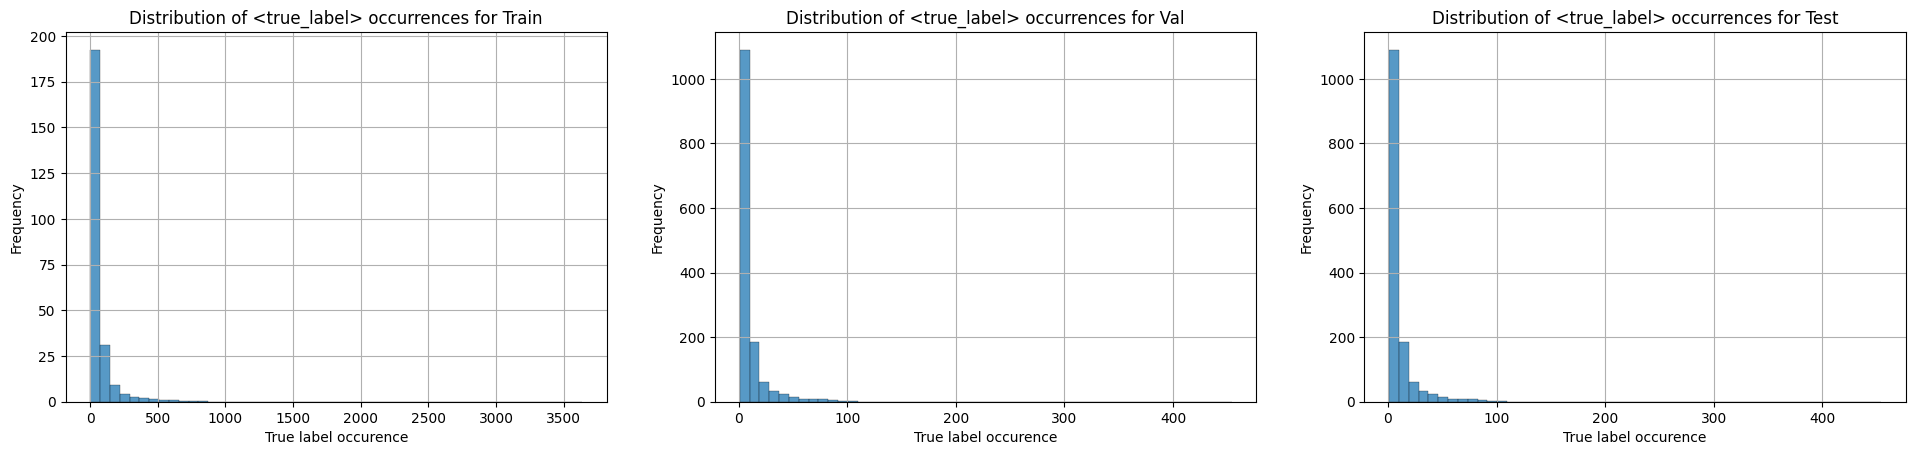

In [ ]:
plt.subplot(1, 3, 1)
plot_family_dist(train_df, 'Train')

plt.subplot(1, 3, 2)
plot_family_dist(dev_df, 'Val')

plt.subplot(1, 3, 3)
plot_family_dist(test_df, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

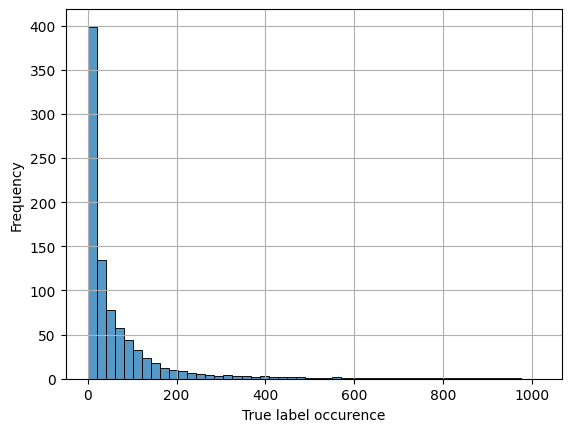

In [ ]:
family_sizes = total_data_df.groupby('true_label').size()

# skip labels that appear the most
family_sizes_sorted = family_sizes.sort_values(ascending=False)[50:]

sns.histplot(family_sizes_sorted, stat='frequency', bins=50)
plt.xlabel('True label occurence')
plt.grid(True)

**Conclusion**: Most of the true_label (target variable) appear < 100 times, meaning there is a 'long-tail' of target labels.  

There are some classes which appear even more than 500 times.  

There is a class imbalance in a way that some labels dominant in occurrences. Potentially those occuring the most could be downsampled.



---



---



In [ ]:
dev_df['family_id'].value_counts()

Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
                  ... 
TBD                  1
ICAT                 1
WW_FCH_linker        1
Herpes_UL25          1
Vasculin             1
Name: family_id, Length: 13071, dtype: int64

In [ ]:
# Check for class imbalance
print(dev_df['family_id'].value_counts(normalize=True))

Methyltransf_25    0.003598
LRR_1              0.001902
Acetyltransf_7     0.001736
His_kinase         0.001522
Bac_transf         0.001506
                     ...   
TBD                0.000008
ICAT               0.000008
WW_FCH_linker      0.000008
Herpes_UL25        0.000008
Vasculin           0.000008
Name: family_id, Length: 13071, dtype: float64


## Filtering Dataset

Mostly due to limits in computation power, the dataset is reduced in size.  

Only consider sequences with lengths between 50 and 250 to accelerate experimentation. In real-life settings, it is important to leverage all the available data, but that would necessitate more computational resources.  

### Keep only the true labels that are present in all 3 partitions

In [ ]:
train_true_labels = set(train_df.true_label.unique())
dev_true_labels = set(dev_df.true_label.unique())

In [ ]:
train_labels_extra = train_true_labels - dev_true_labels

In [ ]:
train_df[train_df.true_label.isin(train_labels_extra)].groupby('true_label').size().sort_values(ascending=False)

true_label
PF00015    9
PF11822    9
PF04805    9
PF04837    9
PF17250    9
          ..
PF03569    1
PF10624    1
PF10653    1
PF10654    1
PF10379    1
Length: 4858, dtype: int64

Families exclusive to the training have at most 9 examples in this dataset. Total number of samples with classes present only in training set is 4858. Therefore, they can be ignored for the rest of this work.

In [ ]:
train_df = train_df[~train_df.true_label.isin(train_labels_extra)]

In [ ]:
len(train_df.true_label.unique())

13071

In [ ]:
train_df.shape

(1064950, 7)

4858 samples were removed from the training dataset, since their target label is not present in dev/test sets.

### Only consider sequences with length in range [50 : 250]

Only consider sequences with lengths between 50 and 250 to accelerate experimentation. 

In [ ]:
MIN_SEQ_LEN, MAX_SEQ_LEN = 50, 250

In [ ]:
train_df = train_df[train_df.seq_length.between(MIN_SEQ_LEN, MAX_SEQ_LEN, inclusive='both')]
dev_df = dev_df[dev_df.seq_length.between(MIN_SEQ_LEN, MAX_SEQ_LEN, inclusive='both')]
test_df = test_df[test_df.seq_length.between(MIN_SEQ_LEN, MAX_SEQ_LEN, inclusive='both')]

In [ ]:
partition_names = ['Train', 'Dev', 'Test']

In [ ]:
def partitions_info(frames, names):
  return pd.DataFrame([
    {
      'partition': name,
      'num_of_samples': frame.shape[0],
      'num_of_true_class': frame['true_label'].unique().size,
      'max_samples_per_class': frame.groupby('true_label').size().max(),
      'min_samples_per_class': frame.groupby('true_label').size().min(),
      'min_seq_length': frame['seq_length'].min(),
      'max_seq_length': frame['seq_length'].max(),
      'avg_seq_length': frame['seq_length'].mean()
    } for name, frame in zip(names, frames)
  ])

In [ ]:
partitions_info([train_df, dev_df, test_df], partition_names)

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,Train,804155,10275,3637,1,50,250,122.271796
1,Dev,95325,9975,454,1,50,250,122.088308
2,Test,95361,9968,454,1,50,250,122.111251


### Consider only 5% of target labels (most frequent ones)

In [ ]:
# Take 10% of the total number of classes availabel in the Pfam dataset
num_target_classes = int(0.05 * 17929)

num_target_classes

896

In [ ]:
most_freq_classes = set(
    (train_df.groupby('true_label').size()
                                   .sort_values(ascending=False)
                                   .head(num_target_classes)
                                   .keys())
)

In [ ]:
train_df = train_df[train_df.true_label.isin(most_freq_classes)]
dev_df = dev_df[dev_df.true_label.isin(most_freq_classes)]
test_df = test_df[test_df.true_label.isin(most_freq_classes)]

In [ ]:
partitions_info([train_df, dev_df, test_df], partition_names)

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,Train,360946,896,3637,192,50,250,118.592524
1,Dev,44621,896,454,22,50,250,118.555456
2,Test,44639,896,454,23,50,250,118.574229


### Add the encoded 'true_label' to datasets

In [ ]:
from sklearn import preprocessing

In [ ]:
# Get labels 
train_labels = train_df["true_label"].tolist()
test_labels = test_df["true_label"].tolist()
dev_labels = dev_df["true_label"].tolist()

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(train_labels)

LabelEncoder()

In [ ]:
train_labels = le.transform(train_labels)
dev_labels = le.transform(dev_labels)
test_labels = le.transform(test_labels)

In [ ]:
num_classes = len(list(le.classes_))
num_classes

896

In [ ]:
le.inverse_transform([0])

array(['PF00003'], dtype='<U7')

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(len(le_name_mapping))

896


In [ ]:
le_name_mapping['PF00003']

0

In [ ]:
train_df["true_label_encoded"] = train_labels
test_df["true_label_encoded"] = test_labels
dev_df["true_label_encoded"] = dev_labels



---



---



In [ ]:
train_df.to_csv('/content/drive/MyDrive/instaDeep/data/train_filtered.csv', index=False)
dev_df.to_csv('/content/drive/MyDrive/instaDeep/data/dev_filtered.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/instaDeep/data/test_filtered.csv', index=False)